In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from collections import defaultdict, Counter

### Dataset Loading, Analysis, & Insight

In [3]:
df = pd.read_csv('dataset/groceries_dataset.csv')
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nSample data:")
print(df.head())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Top 10 most frequent items
item_counts = df['itemDescription'].value_counts()
print("\nTop 10 most frequent items:")
print(item_counts.head(10))

Dataset shape: (38765, 3)
Columns: ['Member_number', 'Date', 'itemDescription']

Sample data:
   Member_number        Date   itemDescription
0           1808  21-07-2015    tropical fruit
1           2552  05-01-2015        whole milk
2           2300  19-09-2015         pip fruit
3           1187  12-12-2015  other vegetables
4           3037  01-02-2015        whole milk

Missing values per column:
Member_number      0
Date               0
itemDescription    0
dtype: int64

Top 10 most frequent items:
itemDescription
whole milk          2502
other vegetables    1898
rolls/buns          1716
soda                1514
yogurt              1334
root vegetables     1071
tropical fruit      1032
bottled water        933
sausage              924
citrus fruit         812
Name: count, dtype: int64


### Dataset Preparation

Total transactions (Member & Date): 14963
Total transactions (Member & Month): 13905
Total transactions (Member All-Time): 3898


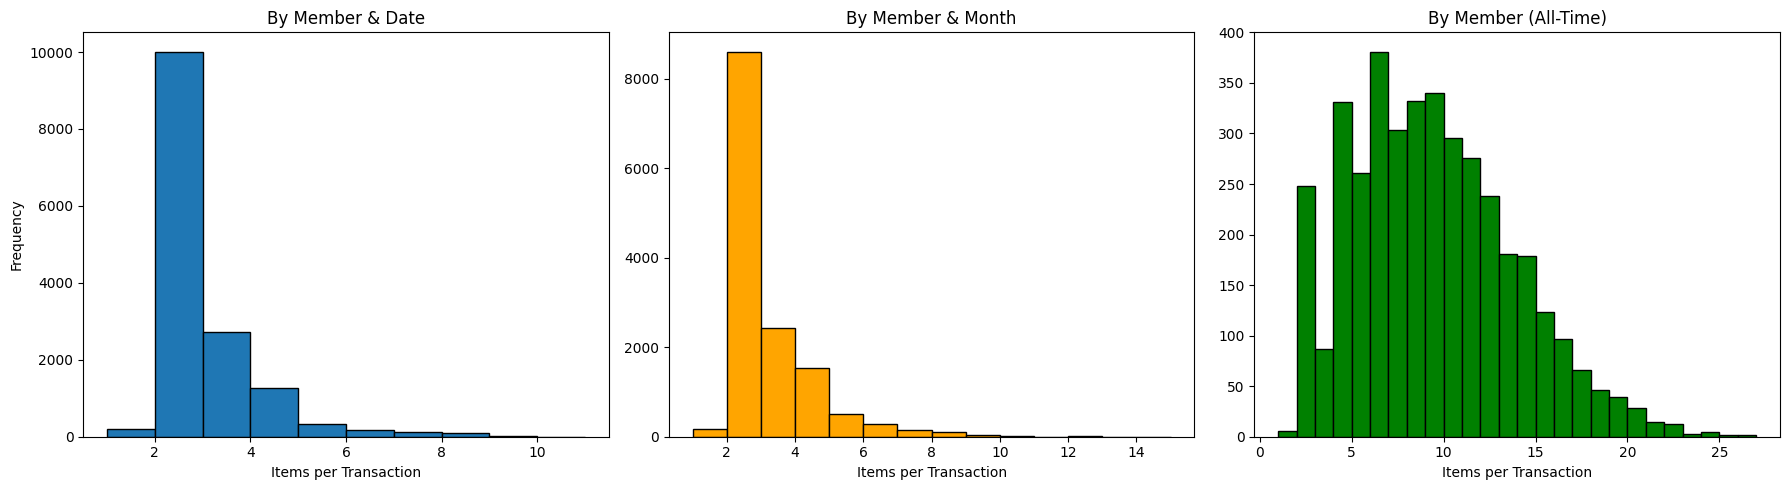

In [23]:
# 1. By (Member_number, Date)
transactions1 = df.groupby(['Member_number', 'Date'])['itemDescription'].apply(set).tolist()
lengths1 = [len(t) for t in transactions1]
print(f"Total transactions (Member & Date): {len(transactions1)}")

# 2. By (Member_number, YearMonth)
transactions2 = df.groupby(['Member_number', 'YearMonth'])['itemDescription'].apply(set).tolist()
lengths2 = [len(t) for t in transactions2]
print(f"Total transactions (Member & Month): {len(transactions2)}")

# 3. By Member_number (all-time basket)
transactions3 = df.groupby('Member_number')['itemDescription'].apply(set).tolist()
lengths3 = [len(t) for t in transactions3]
print(f"Total transactions (Member All-Time): {len(transactions3)}")


# Plot side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

axes[0].hist(lengths1, bins=range(1, max(lengths1)+2), edgecolor='black')
axes[0].set_title('By Member & Date')
axes[0].set_xlabel('Items per Transaction')
axes[0].set_ylabel('Frequency')

axes[1].hist(lengths2, bins=range(1, max(lengths2)+2), edgecolor='black', color='orange')
axes[1].set_title('By Member & Month')
axes[1].set_xlabel('Items per Transaction')

axes[2].hist(lengths3, bins=range(1, max(lengths3)+2), edgecolor='black', color='green')
axes[2].set_title('By Member (All-Time)')
axes[2].set_xlabel('Items per Transaction')

plt.tight_layout()
plt.show()

In [24]:
transactions, num_transactions = transactions3, len(transactions3)

### Apriori Algorithm

In [ ]:
def get_frequent_itemsets(transactions, min_support):
    itemsets = dict()
    # 1-itemsets
    item_counts = defaultdict(int)
    for t in transactions:
        for item in t:
            item_counts[frozenset([item])] += 1
    L1 = {itemset: count/num_transactions for itemset, count in item_counts.items() if count/num_transactions >= min_support}
    itemsets.update(L1)
    Lk = L1
    k = 2
    while Lk:
        prev_itemsets = list(Lk.keys())
        # Self-join: generate candidate k-itemsets
        candidates = set()
        for i in range(len(prev_itemsets)):
            for j in range(i+1, len(prev_itemsets)):
                union = prev_itemsets[i] | prev_itemsets[j]
                if len(union) == k:
                    candidates.add(union)
        # Prune: only keep candidates whose all (k-1)-subsets are frequent
        pruned_candidates = set()
        for candidate in candidates:
            if all(frozenset(subset) in Lk for subset in combinations(candidate, k-1)):
                pruned_candidates.add(candidate)
        # Count support for candidates
        candidate_counts = defaultdict(int)
        for t in transactions:
            for candidate in pruned_candidates:
                if candidate.issubset(t):
                    candidate_counts[candidate] += 1
        Lk = {itemset: count/num_transactions for itemset, count in candidate_counts.items() if count/num_transactions >= min_support}
        itemsets.update(Lk)
        k += 1
    return itemsets

def generate_association_rules(itemsets, min_confidence):
    """Generate strong association rules from frequent itemsets."""
    rules = []
    for itemset in itemsets:
        if len(itemset) < 2:
            continue
        for i in range(1, len(itemset)):
            for antecedent in combinations(itemset, i):
                antecedent = frozenset(antecedent)
                consequent = itemset - antecedent
                if not consequent:
                    continue
                support_itemset = itemsets[itemset]
                support_antecedent = itemsets.get(antecedent, 0)
                if support_antecedent == 0:
                    continue
                confidence = support_itemset / support_antecedent
                if confidence >= min_confidence:
                    rules.append({
                        'antecedent': set(antecedent),
                        'consequent': set(consequent),
                        'support': support_itemset,
                        'confidence': confidence
                    })
    return rules

### Parameter Selection

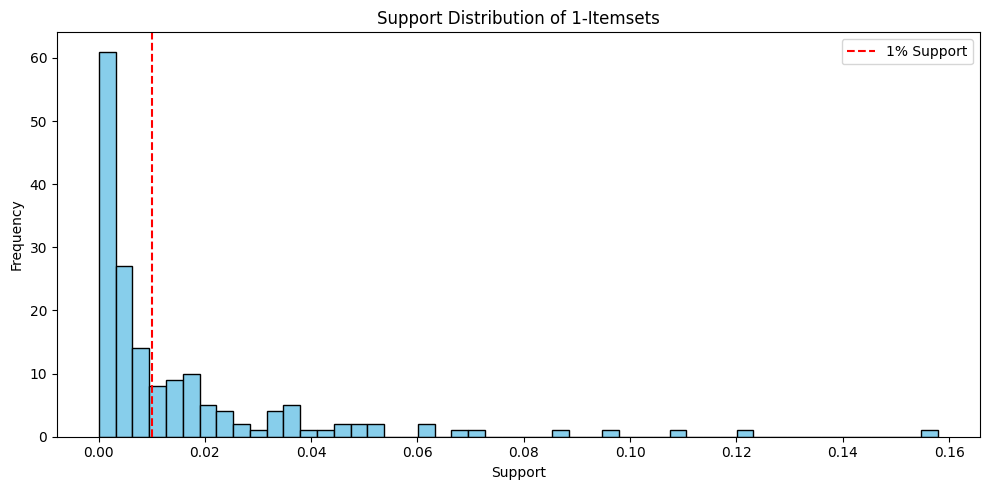

In [6]:
all_items = [item for t in transactions for item in t]
item_supports = pd.Series(Counter(all_items)) / num_transactions
plt.figure(figsize=(10,5))
plt.hist(item_supports, bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=0.01, color='red', linestyle='--', label='1% Support')
plt.title('Support Distribution of 1-Itemsets')
plt.xlabel('Support')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

### Algorithm Implementation

In [18]:
min_support = 0.01   # 1%
min_confidence = 0.6 # 60%

print("\nRunning Apriori algorithm...")
itemsets = get_frequent_itemsets(transactions, min_support)
print(f"Found {len(itemsets)} frequent itemsets.")

rules = generate_association_rules(itemsets, min_confidence)
print(f"Found {len(rules)} strong association rules (confidence >= {min_confidence*100:.0f}%).")



Running Apriori algorithm...


Found 3016 frequent itemsets.
Found 291 strong association rules (confidence >= 60%).


In [19]:
print("\nSample of strong association rules:")
for rule in sorted(rules, key=lambda x: -x['confidence'])[:5]:
    ant = ', '.join(rule['antecedent'])
    cons = ', '.join(rule['consequent'])
    print(f"[{ant}] => [{cons}] | support: {rule['support']:.3f}, confidence: {rule['confidence']:.2f}")



Sample of strong association rules:
[meat, domestic eggs] => [whole milk] | support: 0.010, confidence: 0.78
[chocolate, fruit/vegetable juice] => [whole milk] | support: 0.011, confidence: 0.75
[yogurt, rolls/buns, other vegetables, bottled water] => [whole milk] | support: 0.011, confidence: 0.75
[yogurt, pip fruit, bottled water] => [whole milk] | support: 0.010, confidence: 0.74
[yogurt, rolls/buns, brown bread] => [whole milk] | support: 0.013, confidence: 0.74


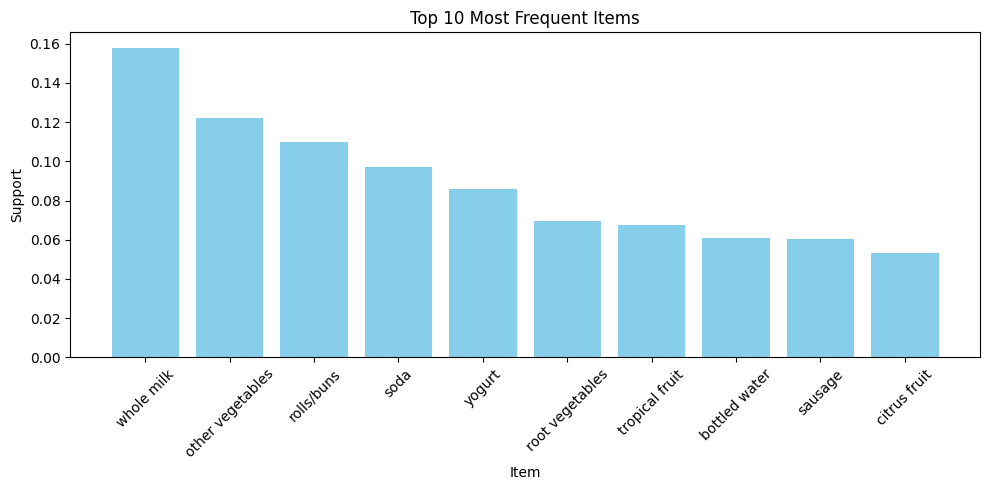

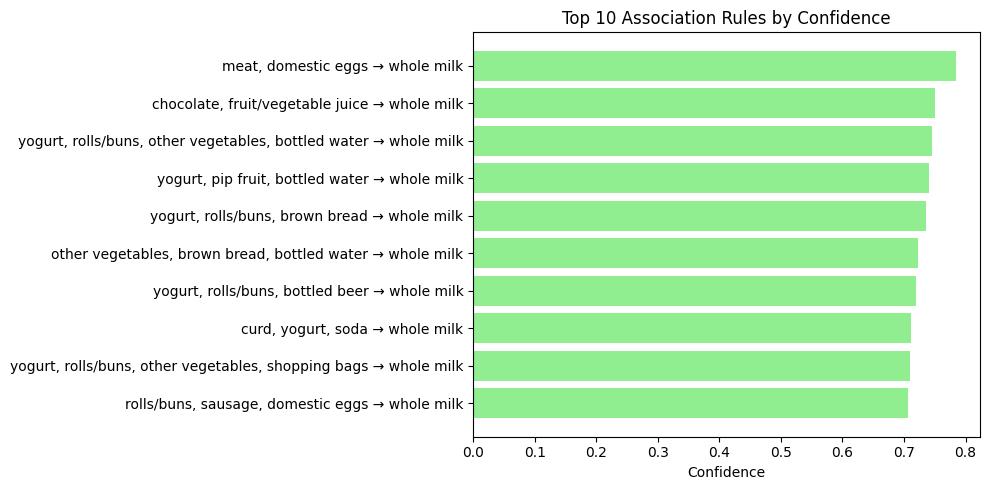

In [20]:
# Top 10 frequent items
top_items = item_supports.sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
plt.bar(top_items.index, top_items.values, color='skyblue')
plt.xlabel('Item')
plt.ylabel('Support')
plt.title('Top 10 Most Frequent Items')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Top 10 rules by confidence
rules_df = pd.DataFrame(rules)
if not rules_df.empty:
    rules_df['rule'] = rules_df['antecedent'].apply(lambda x: ', '.join(x)) + ' → ' + rules_df['consequent'].apply(lambda x: ', '.join(x))
    top_rules = rules_df.sort_values(by='confidence', ascending=False).head(10)
    plt.figure(figsize=(10,5))
    plt.barh(top_rules['rule'], top_rules['confidence'], color='lightgreen')
    plt.xlabel('Confidence')
    plt.title('Top 10 Association Rules by Confidence')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("No rules to visualize.")
